# Preprocessing

### Load all climate data (Precip & Soil Moisture) station F102 - F108

In [199]:
%run -i function_timeseries.py


current_directory = os.getcwd()
path_to_save = current_directory+r'/F108_Tseries'
os.makedirs(path_to_save, exist_ok=True)


In [200]:
df_station = pd.read_excel(os.getcwd()+"/Inputs/Physiography Data.xlsx",
                           engine="openpyxl", sheet_name=None, skiprows=1,)

# Print the name of each sheets


5 Stations with different soil profiles and slope.


## Load all the precipitation in the stations

In [201]:
station_name = list(df_station.keys())[:5]
station_name

['F102', 'F106', 'F107', 'F108', 'F110']

## Precipitation of all the stations


In [202]:
precipitation = df_station['F102'].iloc[:, :2].set_index('Date')

for i in station_name:
    precipitation = precipitation.merge(df_station[i].iloc[:, :2].set_index(
        'Date').rename(columns={'mm': i}), left_index=True, right_index=True)
precipitation = precipitation.drop(columns='mm')

precipitation = precipitation.replace([-996,-999], np.nan)
precipitation.describe()

F102         F106         F107         F108         F110
count  5616.000000  5648.000000  3981.000000  5661.000000  5642.000000
mean      2.125741     2.066737     2.039206     2.019604     2.144523
std       7.847348     7.646972     7.632055     7.489740     8.103167
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000     0.000000     0.000000
max     142.750000   171.450000   170.940000   160.270000   171.450000

dict_keys(['F102', 'F106', 'F107', 'F108', 'F110', 'MESONET HINT_TEMP', 'Discharge', 'Soils_Slopes'])


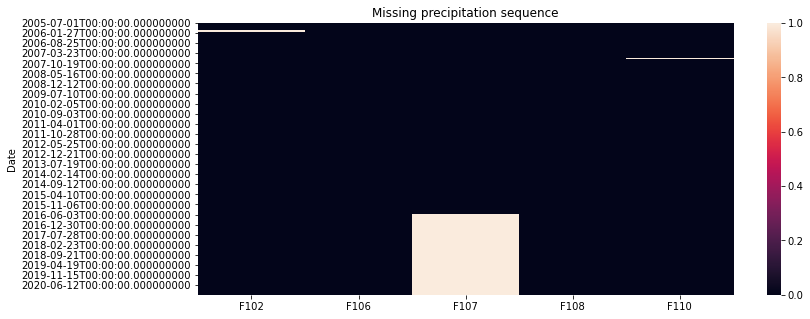

In [203]:
# ReLoad the excel
data = pd.read_excel(os.getcwd()+"/Inputs/Physiography Data.xlsx",
                     engine="openpyxl", sheet_name=None, )
print(data.keys())
fig, ax = plt.subplots(figsize=(12, 5))
plt.title('Missing precipitation sequence')
sns.heatmap(precipitation.isna())
plt.show()

Micronet Stations  Slope %       Texture  No. Layers  Max Depth (mm)
0              f102      5.9  LFS-FSL-SL-L           4            1829
1              f106      5.5      FSL-SICL           2            1727
2              f107      0.5      FSL-SICL           2            1727
3              f108      3.7      FSL-SICL           2            1727
4              f110      2.8      FSL-SICL           2            1727

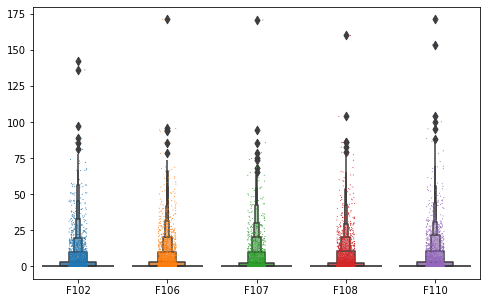

In [204]:
fig,ax = plt.subplots(figsize=(8,5))
sns.stripplot(data=precipitation, size= 1)
sns.boxenplot(data=precipitation)
data['Soils_Slopes']


In [205]:
precipitation.describe()

F102         F106         F107         F108         F110
count  5616.000000  5648.000000  3981.000000  5661.000000  5642.000000
mean      2.125741     2.066737     2.039206     2.019604     2.144523
std       7.847348     7.646972     7.632055     7.489740     8.103167
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000     0.000000     0.000000
max     142.750000   171.450000   170.940000   160.270000   171.450000

Stations with the least missing precipitaion values are preferred for analysis listed below in descending order
- F106
- F110
- F102
- F107

Check the correlation between the precipitation at the different station 

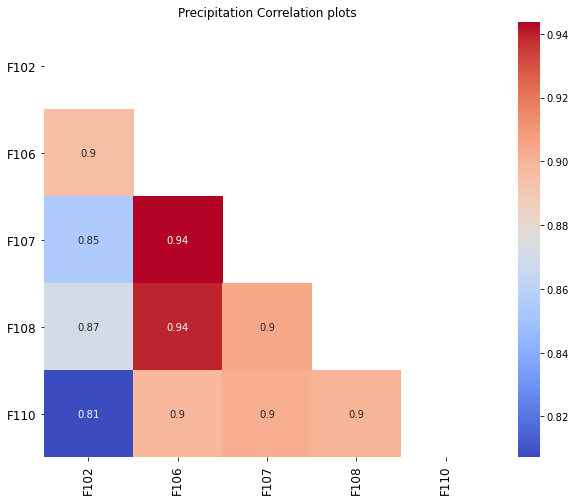

In [206]:
corr_plot(precipitation, 'Precipitation Correlation plots')

We choose the station with the most complete precipitation "F108".
<mark>F108</mark> has a high correlation with <mark>F106</mark> station that happens to be the next complete.
They both have the same soil property but different slopes


In [207]:
data["Soils_Slopes"]

Micronet Stations  Slope %       Texture  No. Layers  Max Depth (mm)
0              f102      5.9  LFS-FSL-SL-L           4            1829
1              f106      5.5      FSL-SICL           2            1727
2              f107      0.5      FSL-SICL           2            1727
3              f108      3.7      FSL-SICL           2            1727
4              f110      2.8      FSL-SICL           2            1727

## Load the Temperature data

We have a single temperature data for all the stations located in sheetnamae <mark> MESONET HINT_TEMP</mark>

In [208]:
# Obtain the Mesonet Temperature Min and Max temperature
Temperature = data["MESONET HINT_TEMP"].set_index('Date')
#Temperature.rename(columns={"TMAX (C)" : "TMAX ", 'TMIN (C)': "TMAX"})

# Merge the temperature and precipitation for the F108 station
df_F108 = Temperature.merge(precipitation['F108'], how='inner', on='Date')
df_F108 = df_F108.rename(columns={'F108': "PRCP (mm)"})
# create the discharge column
df_F108["CMS"] = data["Discharge"].set_index('Date').loc['2005-07-01':]


# replace all odd values due to  wrong instrument reading
#  and linear interpolate missing values.

df_F108 = df_F108.replace(-571.105400, np.nan)
df_F108 = df_F108.interpolate(method='linear', limit_direction='both')
status(df_F108)


Features     Observations    No of missing   % Missing
----------  --------------  ---------------  ------------
TMAX (C)         5663              0         0.0%
TMIN (C)         5663              0         0.0%
PRCP (mm)        5663              0         0.0%
CMS              5663              0         0.0%


## Merge the soil properties, temperature and precipitation 

In [209]:
df_F108 = df_F108.merge(df_station['F108'].drop(columns='mm'),
                        how='inner', on='Date')

# set the date as the index of the dataframe
df_F108 = df_F108.set_index('Date')

# Rename the soil columns
df_F108 = df_F108.rename(columns={"5 cm": "SM 5 (cm)",
                                  "25 cm": "SM 25 (cm)",
                                  "45 cm": "SM 45 (cm)"})

### Deal with the missing values.

In [210]:
# replace all the -998  adn -996 with np.nan
df_F108 = df_F108.replace([-998, -996], np.nan)

status(df_F108)

Features     Observations    No of missing   % Missing
----------  --------------  ---------------  ------------
TMAX (C)         5663              0         0.0%
TMIN (C)         5663              0         0.0%
PRCP (mm)        5663              0         0.0%
CMS              5663              0         0.0%
SM 5 (cm)        5663             88         1.6%
SM 25 (cm)       5663             88         1.6%
SM 45 (cm)       5663             88         1.6%


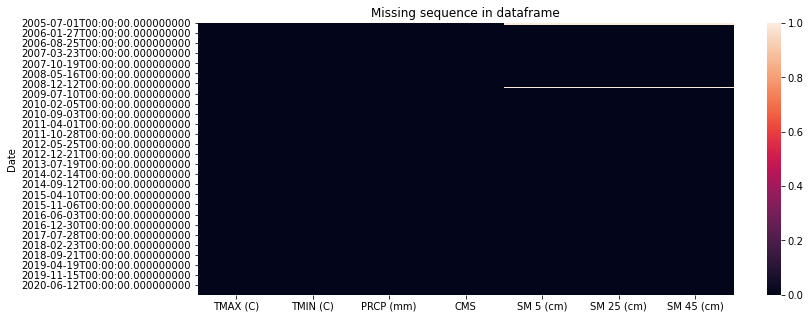

In [211]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(df_F108.isna())
plt.title("Missing sequence in dataframe")
plt.show()

In [212]:
display_side_by_side([sequence_of_missing_values(df_F108, 'SM 5 (cm)'),
                     sequence_of_missing_values(df_F108, 'SM 25 (cm)'), sequence_of_missing_values(df_F108, 'SM 45 (cm)')],
                     ['5cm', '25cm', '45cm']
                     )


Drop the first 56 rows till 2005-08-26 and linear interpolate the dataframe

In [213]:
df_F108 = df_F108.loc['2005-08-26':].interpolate(
    method='linear', limit_direction='both')
status(df_F108)

Features     Observations    No of missing   % Missing
----------  --------------  ---------------  ------------
TMAX (C)         5607              0         0.0%
TMIN (C)         5607              0         0.0%
PRCP (mm)        5607              0         0.0%
CMS              5607              0         0.0%
SM 5 (cm)        5607              0         0.0%
SM 25 (cm)       5607              0         0.0%
SM 45 (cm)       5607              0         0.0%


# Feature Engineering

- create median and mean precipitations weekly and yearly frequency. 
- check the correlation between features on both time format.
- load the yearly yeild
- Split the data into train and test
- Create the pipeline no tuning yet
-- XGBoost
-- Catboost
-- Random Forest
-- ExtraTree

## Correlation plots

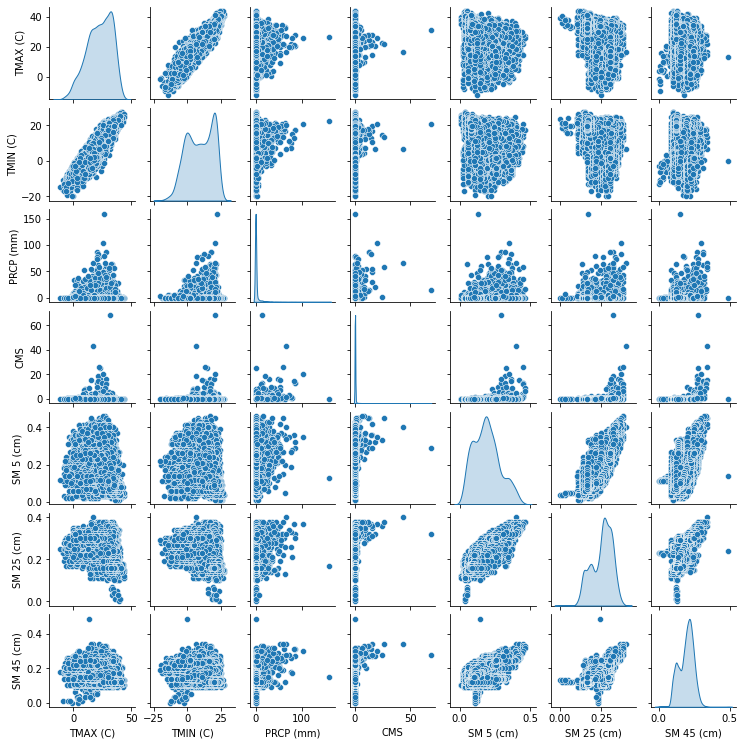

In [214]:
sns.pairplot(df_F108, diag_kind='kde', height=1.5)


### resample to weekly values and check correlation


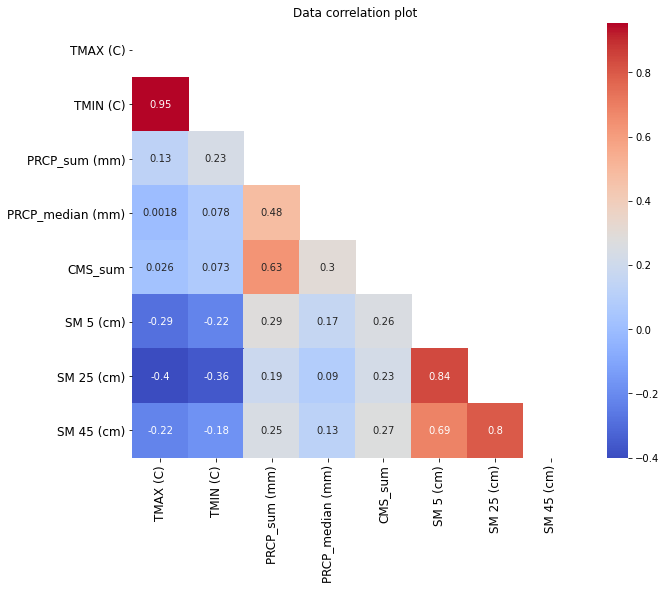

In [215]:
# Resample the temperature
resampled = df_F108[['TMAX (C)', "TMIN (C)"]].resample('W').median()
# Resample the Precipitation sum and median
resampled["PRCP_sum (mm)"] = df_F108["PRCP (mm)"].resample('W').sum()
resampled["PRCP_median (mm)"] = df_F108["PRCP (mm)"].resample('W').median()
# Resample the discharge sum
resampled["CMS_sum"] = df_F108["CMS"].resample('W').sum()
# Resample the SM
resampled_SM = df_F108.iloc[:, 4:].resample('W').mean()
# The transformed precipitation mean and median

df_F108_resampled = resampled.merge(resampled_SM, on='Date', how="inner")


corr_plot(df_F108_resampled, 'Data correlation plot')


The pearson correlation shows that the resampled weekly mean PRCP (mm) has a higher correlation with other features than the median

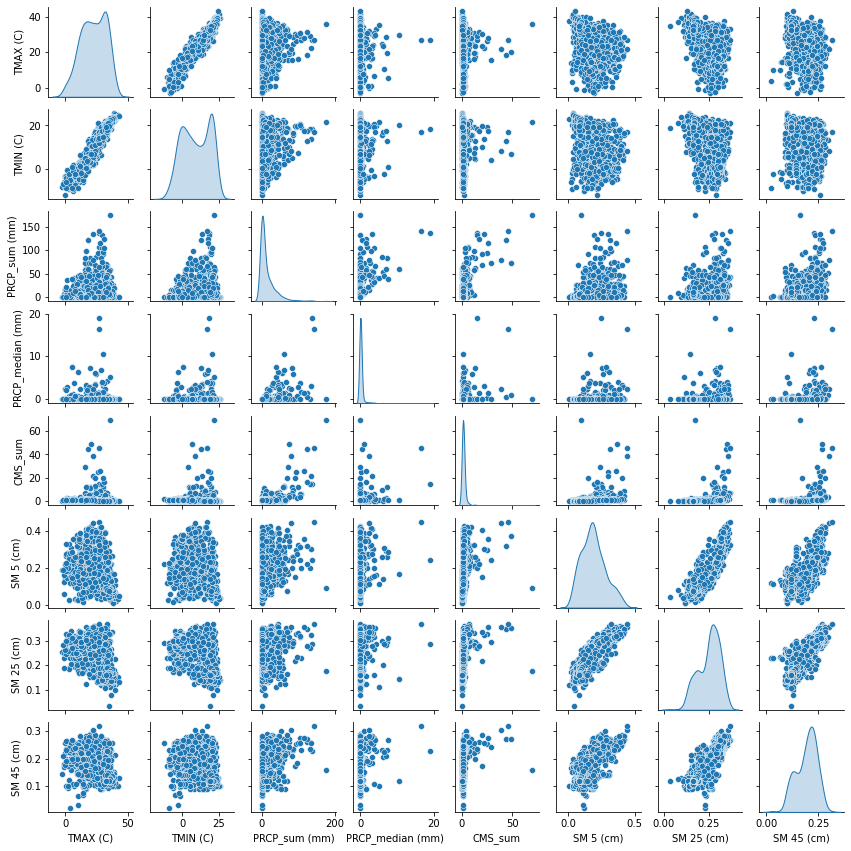

In [216]:
sns.pairplot(df_F108_resampled, diag_kind='kde', height=1.5)


# df_AI

In [217]:
df_AI = df_F108_resampled.drop(columns=["PRCP_median (mm)"])

df_AI = df_AI.rename(columns={"PRCP_sum (mm)": "$P [mm]$",
                              "TMAX (C)": "$T_{max}$ [$^oC$]",
                              "TMIN (C)": '$T_{min}$ [$^oC$]',
                              "SM 5 (cm)": "$SM_{5} [cm]$",
                              "SM 25 (cm)": "$SM_{25} [cm]$",
                              "SM 45 (cm)": "$SM_{45} [cm]$",
                              "CMS_sum": "$Dis [CMS]$"})

df_AI['Month'] = df_AI.index.month

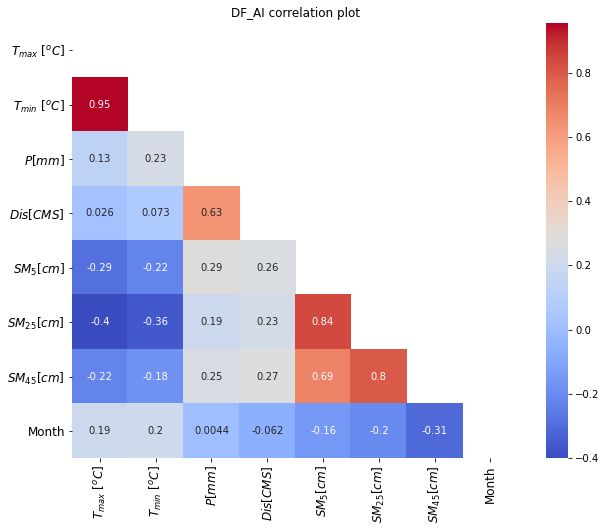

In [218]:
corr_plot(df_AI, 'DF_AI correlation plot')

In [219]:
df_AI_SM5 = df_AI.copy()

In [220]:


# Precipitation Lags
#df_AI['$P^{lag1} [mm]$'] = df_AI["$P [mm]$"].shift(1)
#df_AI['$P^{lag2} [mm]$'] = df_AI["$P [mm]$"].shift(2)

# Soil Moisture Lags
df_AI_SM5["$SM_{5}^{lag1}[cm]$"] = df_AI_SM5["$SM_{5} [cm]$"].shift(1)
df_AI_SM5["$SM_{5}^{lag2}[cm]$"] = df_AI_SM5["$SM_{5} [cm]$"].shift(2)

# Stack the columns 
month = df_AI_SM5.loc[:, df_AI_SM5.columns.str.startswith('M')]
prcp = df_AI_SM5.loc[:, df_AI_SM5.columns.str.startswith('$P')]
temp = df_AI_SM5.loc[:, df_AI_SM5.columns.str.startswith('$T')]
ds = df_AI_SM5.loc[:, df_AI_SM5.columns.str.startswith('$D')]
sm = df_AI_SM5.loc[:, df_AI_SM5.columns.str.startswith('$S')]

# Merge the dataframe
df_AI_SM5 = month.merge(temp, on='Date').merge(prcp, on='Date').merge(
    ds, on="Date").merge(sm, on="Date").dropna()


# get all the SM 
SM = ['$SM_{5} [cm]$',
         '$SM_{25} [cm]$',
         '$SM_{45} [cm]$', ]


## Build Model Pipeline

# Predicting soil moisture at 5 cm

In [221]:
%run -i function.py

In [222]:
Features =list(df_AI_SM5.drop(columns = SM).columns)
Target = SM[0]

In [223]:

X = df_AI_SM5[Features].values
y = df_AI_SM5[Target].values # SM 5cm


X_train, X_test, y_train, y_test = train_test_split( X, 
                                                    y.ravel(),
                                                     test_size=0.20, 
                                                     shuffle = False)
                                                     


In [224]:

pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner = [pipeline_RF, pipeline_XGB, pipeline_ExTree]


In [225]:
holdem = results(X_train, y_train, X_test, y_test, pipeliner)

+--------------------------------+
|       Training set score       |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.97   | 0.01 |
|   XGBoost    |   1.0    | 0.0  |
|  ExtraTree   |   1.0    | 0.0  |
+--------------+----------+------+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.69   | 0.05 |
|   XGBoost    |   0.66   | 0.06 |
|  ExtraTree   |   0.71   | 0.05 |
+--------------+----------+------+


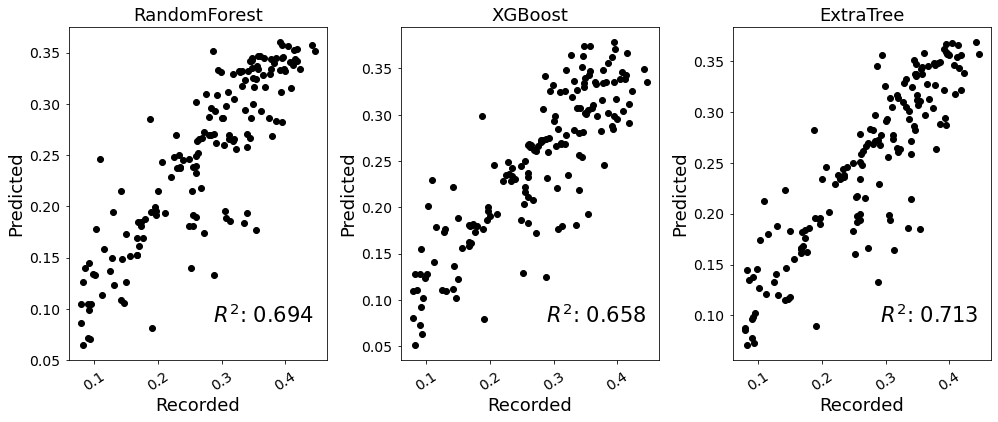

In [226]:
print_results(holdem,y_test)


 XGBoost gives the best results for the test result although performs the least on training 
 while the RMSE is equal for both the XGBoost and the Extratree

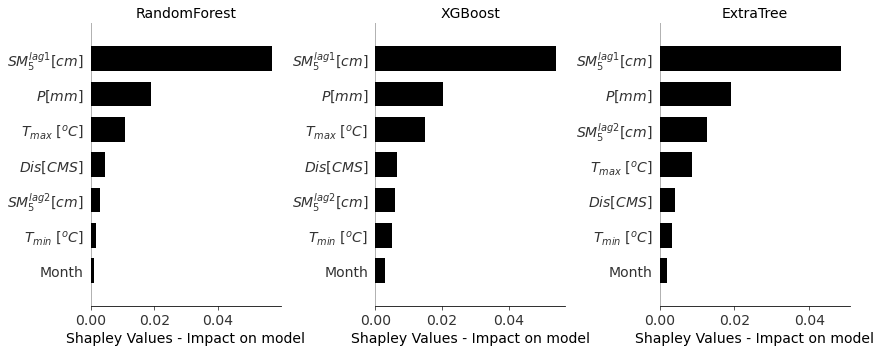

In [227]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(32, 5))
gs = gridspec.GridSpec(1, 3)
keep = {}
for count, model in enumerate(pipeliner):
    Modeled = model[0].fit(X, y.ravel())
    explainer = shap.TreeExplainer(Modeled)
    shap_values = explainer.shap_values(X)
    ax = fig.add_subplot(gs[0, count])
    shap.summary_plot(shap_values, X, Features, show=False,
                      plot_type="bar", color="black", plot_size=(12, 5))
    plt.xlabel('Shapley Values - Impact on model', fontsize=14)
    plt.tick_params(labelsize=14)
    # plt.ylabel(labelsize=16)
    plt.tight_layout(pad=1.2)
    plt.title(model.steps[0][0], fontsize=14)
    keep[model.steps[0][0]] = shap_values
    fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.savefig(path_to_save+r'/Histogram-importance.jpg',
            format='jpeg', dpi=300, bbox_inches='tight')
plt.show()


# Predicting soil moisture at 25 cm

In [228]:
Lag_SM5 = df_AI_SM5[Features].columns.difference(df_AI.columns)

In [229]:
df_SM25 = df_AI.copy()


In [230]:


# Precipitation Lags
#df_AI['$P^{lag1} [mm]$'] = df_AI["$P [mm]$"].shift(1)
#df_AI['$P^{lag2} [mm]$'] = df_AI["$P [mm]$"].shift(2)

# Soil Moisture Lags
df_SM25["$SM_{25}^{lag1}[cm]$"] = df_SM25["$SM_{25} [cm]$"].shift(1)
df_SM25["$SM_{25}^{lag2}[cm]$"] = df_SM25["$SM_{25} [cm]$"].shift(2)

# Stack the columns
month = df_SM25.loc[:, df_SM25.columns.str.startswith('M')]
prcp = df_SM25.loc[:, df_SM25.columns.str.startswith('$P')]
temp = df_SM25.loc[:, df_SM25.columns.str.startswith('$T')]
ds = df_SM25.loc[:, df_SM25.columns.str.startswith('$D')]
sm = df_SM25.loc[:, df_SM25.columns.str.startswith('$S')]

# Merge the dataframe
df_SM25 = month.merge(temp, on='Date').merge(prcp, on='Date').merge(
    ds, on="Date").merge(sm, on="Date").dropna()


Target = SM[1]

Features = list(df_SM25.drop(columns=SM))


In [231]:
X = df_SM25[Features].values
y = df_SM25[Target].values  # SM 25cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3, shuffle=False)


pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner = [pipeline_RF, pipeline_XGB, pipeline_ExTree]


In [232]:
holdem = results(X_train, y_train, X_test, y_test, pipeliner)

+--------------------------------+
|       Training set score       |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.98   | 0.01 |
|   XGBoost    |   1.0    | 0.0  |
|  ExtraTree   |   1.0    | 0.0  |
+--------------+----------+------+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.79   | 0.02 |
|   XGBoost    |   0.79   | 0.02 |
|  ExtraTree   |   0.8    | 0.02 |
+--------------+----------+------+


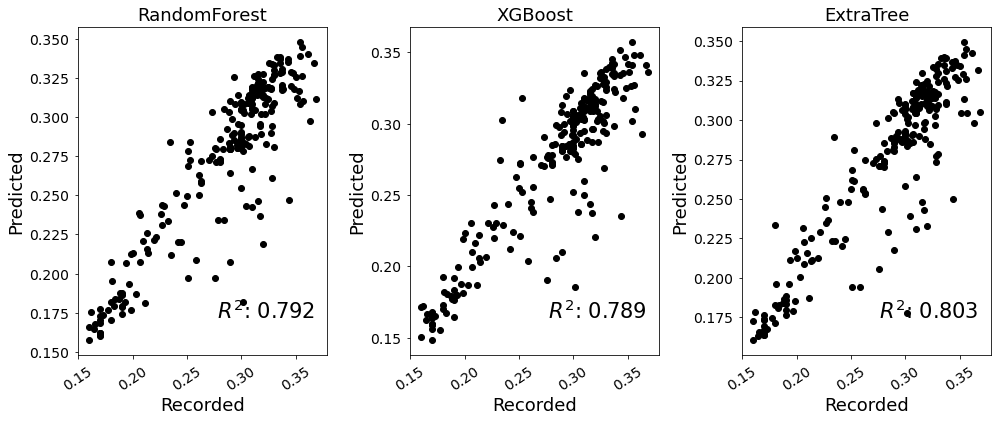

In [233]:
print_results(holdem, y_test)


df_SM25_lag5 = df_SM25.merge(df_AI_SM5[Lag_SM5], on='Date')
Features = list(df_SM25_lag5.drop(columns=SM).columns)
X = df_SM25_lag5[Features].values
y = df_SM25[Target].values # SM 25cm


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y.ravel(),
                                                     test_size=0.3, shuffle=False)
                                                     

pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner = [pipeline_RF, pipeline_XGB, pipeline_ExTree]


#model = pipeline_RF.fit(X_train, y_train)
holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


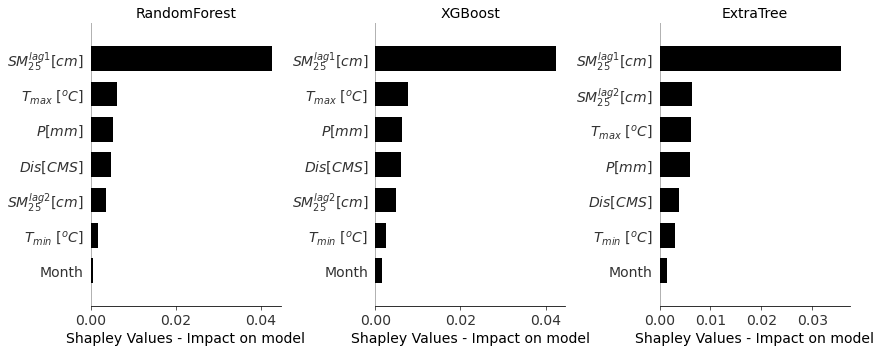

In [234]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(32, 5))
gs = gridspec.GridSpec(1, 3)
keep = {}
for count, model in enumerate(pipeliner):
    Modeled = model[0].fit(X, y.ravel())
    explainer = shap.TreeExplainer(Modeled)
    shap_values = explainer.shap_values(X)
    ax = fig.add_subplot(gs[0, count])
    shap.summary_plot(shap_values, X, Features, show=False,
                      plot_type="bar", color="black", plot_size=(12, 5))
    plt.xlabel('Shapley Values - Impact on model', fontsize=14)
    plt.tick_params(labelsize=14)
    # plt.ylabel(labelsize=16)
    plt.tight_layout(pad=1.2)
    plt.title(model.steps[0][0], fontsize=14)
    keep[model.steps[0][0]] = shap_values
    fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.savefig(path_to_save+r'/Histogram-importance.jpg',
            format='jpeg', dpi=300, bbox_inches='tight')
plt.show()


# Predicting soil moisture at 45 cm

In [247]:
df_SM45 = df_AI.copy()

# Precipitation Lags
#df_AI['$P^{lag1} [mm]$'] = df_AI["$P [mm]$"].shift(1)
#df_AI['$P^{lag2} [mm]$'] = df_AI["$P [mm]$"].shift(2)

# Soil Moisture Lags
df_SM45["$SM_{45}^{lag1}[cm]$"] = df_SM45["$SM_{45} [cm]$"].shift(1)
df_SM45["$SM_{45}^{lag2}[cm]$"] = df_SM45["$SM_{45} [cm]$"].shift(2)

# Stack the columns
month = df_SM45.loc[:, df_SM45.columns.str.startswith('M')]
prcp = df_SM45.loc[:, df_SM45.columns.str.startswith('$P')]
temp = df_SM45.loc[:, df_SM45.columns.str.startswith('$T')]
ds = df_SM45.loc[:, df_SM45.columns.str.startswith('$D')]
sm = df_SM45.loc[:, df_SM45.columns.str.startswith('$S')]

# Merge the dataframe
df_SM45 = month.merge(temp, on='Date').merge(prcp, on='Date').merge(
    ds, on="Date").merge(sm, on="Date").dropna()


Target = SM[2]

Features = list(df_SM45.drop(columns=SM))


In [248]:
Features = list(df_SM45.drop(columns=SM))


In [249]:
X = df_SM45[Features].values
y = df_SM45[Target].values # SM 45cm


X_train, X_test, y_train, y_test = train_test_split( X, 
                                                    y.ravel(),
                                                     test_size=0.3,shuffle = False)
                                                     

pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner = [pipeline_RF, pipeline_XGB, pipeline_ExTree]


#model = pipeline_RF.fit(X_train, y_train)


In [250]:
holdem = results(X_train, y_train, X_test, y_test, pipeliner)

+--------------------------------+
|       Training set score       |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.98   | 0.01 |
|   XGBoost    |   1.0    | 0.0  |
|  ExtraTree   |   1.0    | 0.0  |
+--------------+----------+------+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.83   | 0.02 |
|   XGBoost    |   0.83   | 0.02 |
|  ExtraTree   |   0.85   | 0.02 |
+--------------+----------+------+


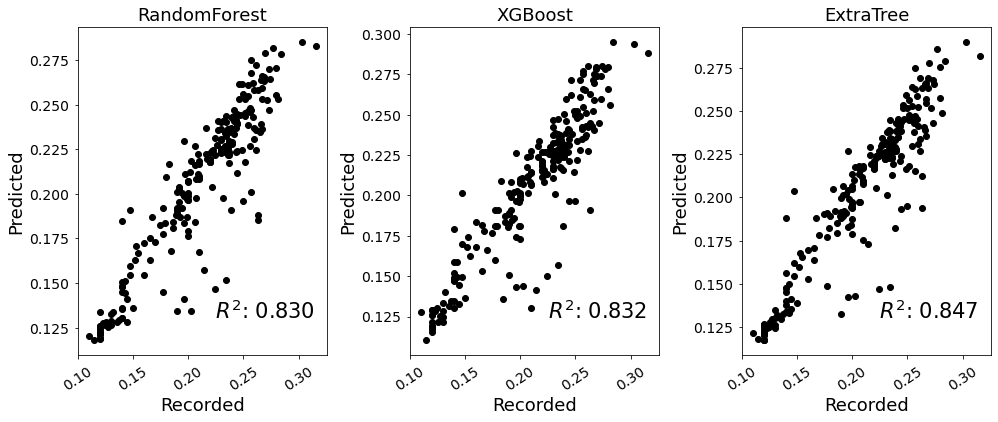

In [251]:
print_results(holdem, y_test)

## Shapley Analysis

In [252]:
current_directory = os.getcwd()
path_to_save = current_directory+r'/F108_Tseries'
os.makedirs(path_to_save, exist_ok=True)

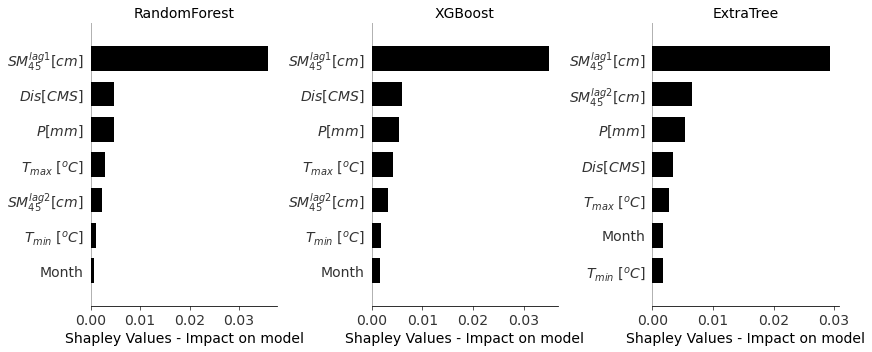

In [253]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(32, 5))
gs = gridspec.GridSpec(1, 3)
keep = {}
for count, model in enumerate(pipeliner):
    Modeled = model[0].fit(X, y.ravel())
    explainer = shap.TreeExplainer(Modeled)
    shap_values = explainer.shap_values(X)
    ax = fig.add_subplot(gs[0, count])
    shap.summary_plot(shap_values, X, Features, show=False,
                      plot_type="bar", color="black", plot_size=(12, 5))
    plt.xlabel('Shapley Values - Impact on model', fontsize=14)
    plt.tick_params(labelsize=14)
    # plt.ylabel(labelsize=16)
    plt.tight_layout(pad=1.2)
    plt.title(model.steps[0][0], fontsize=14)
    keep[model.steps[0][0]] = shap_values
    fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.savefig(path_to_save+r'/Histogram-importance.jpg',
            format='jpeg', dpi=300, bbox_inches='tight')
plt.show()


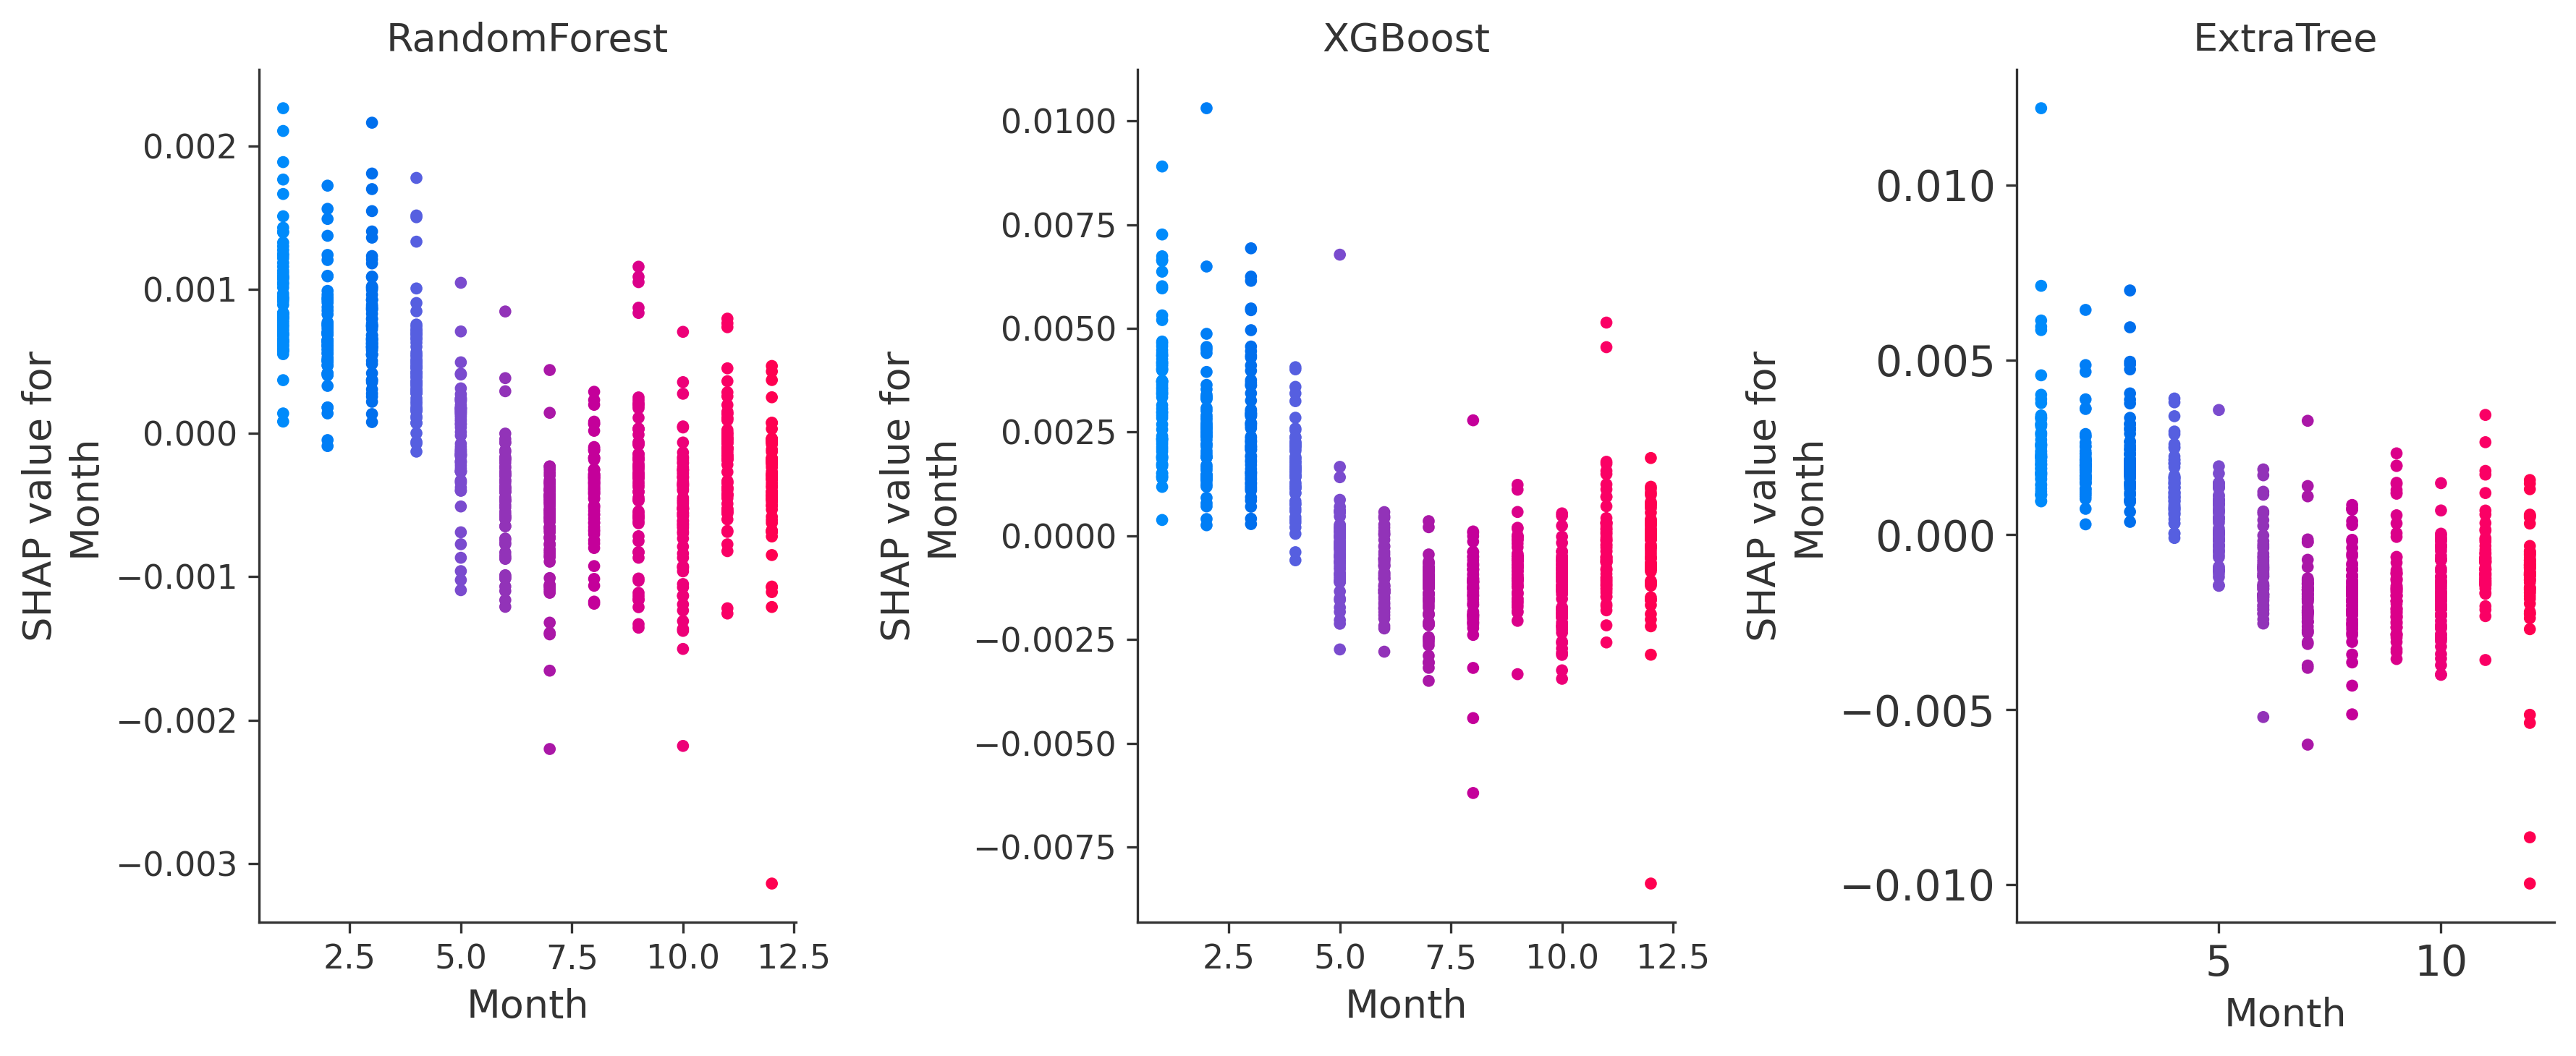

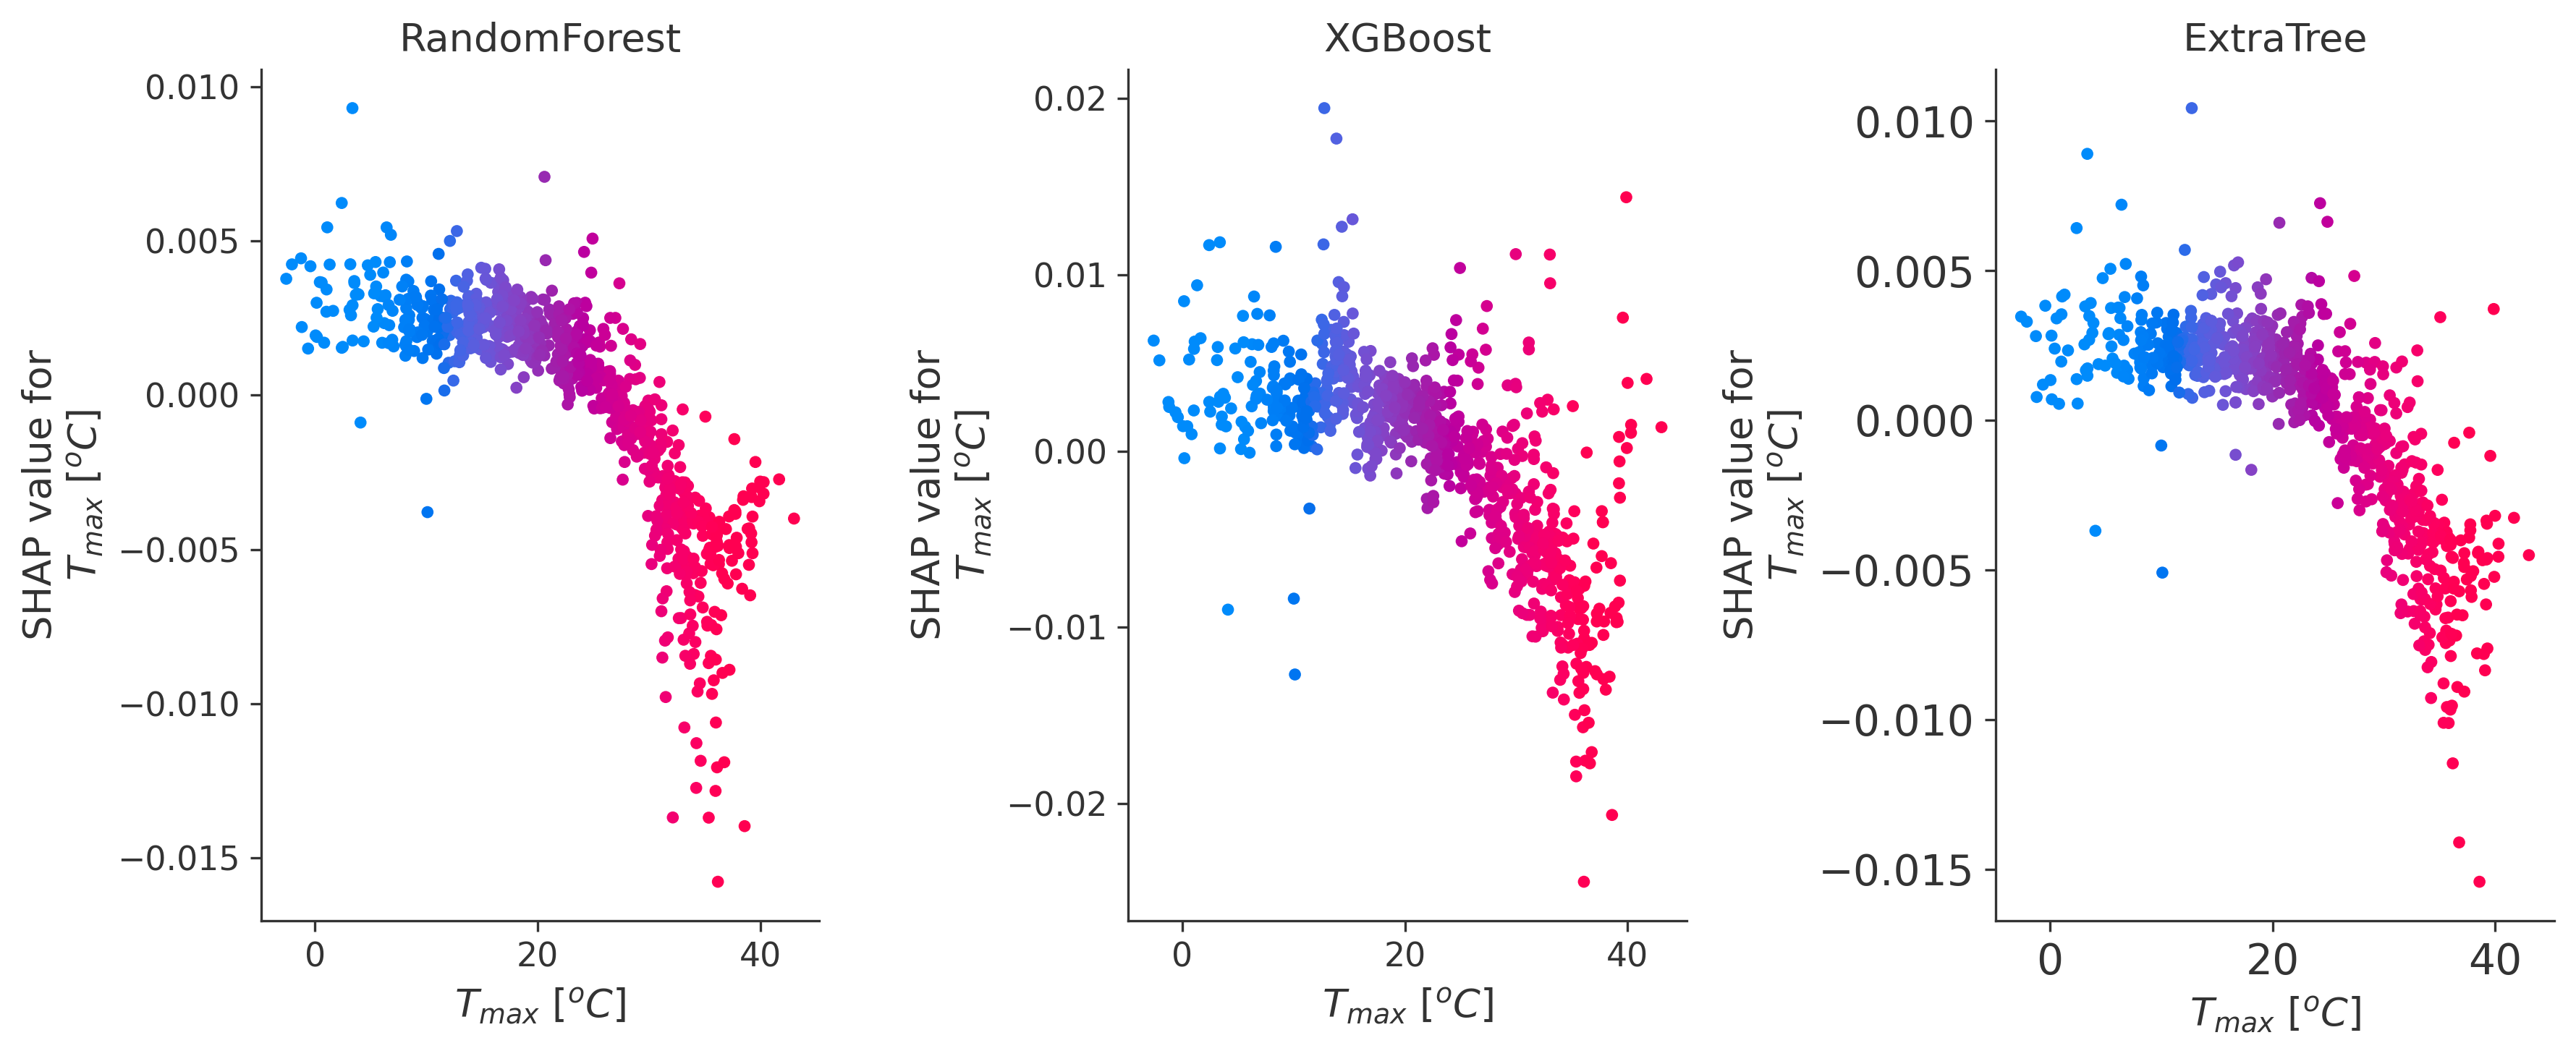

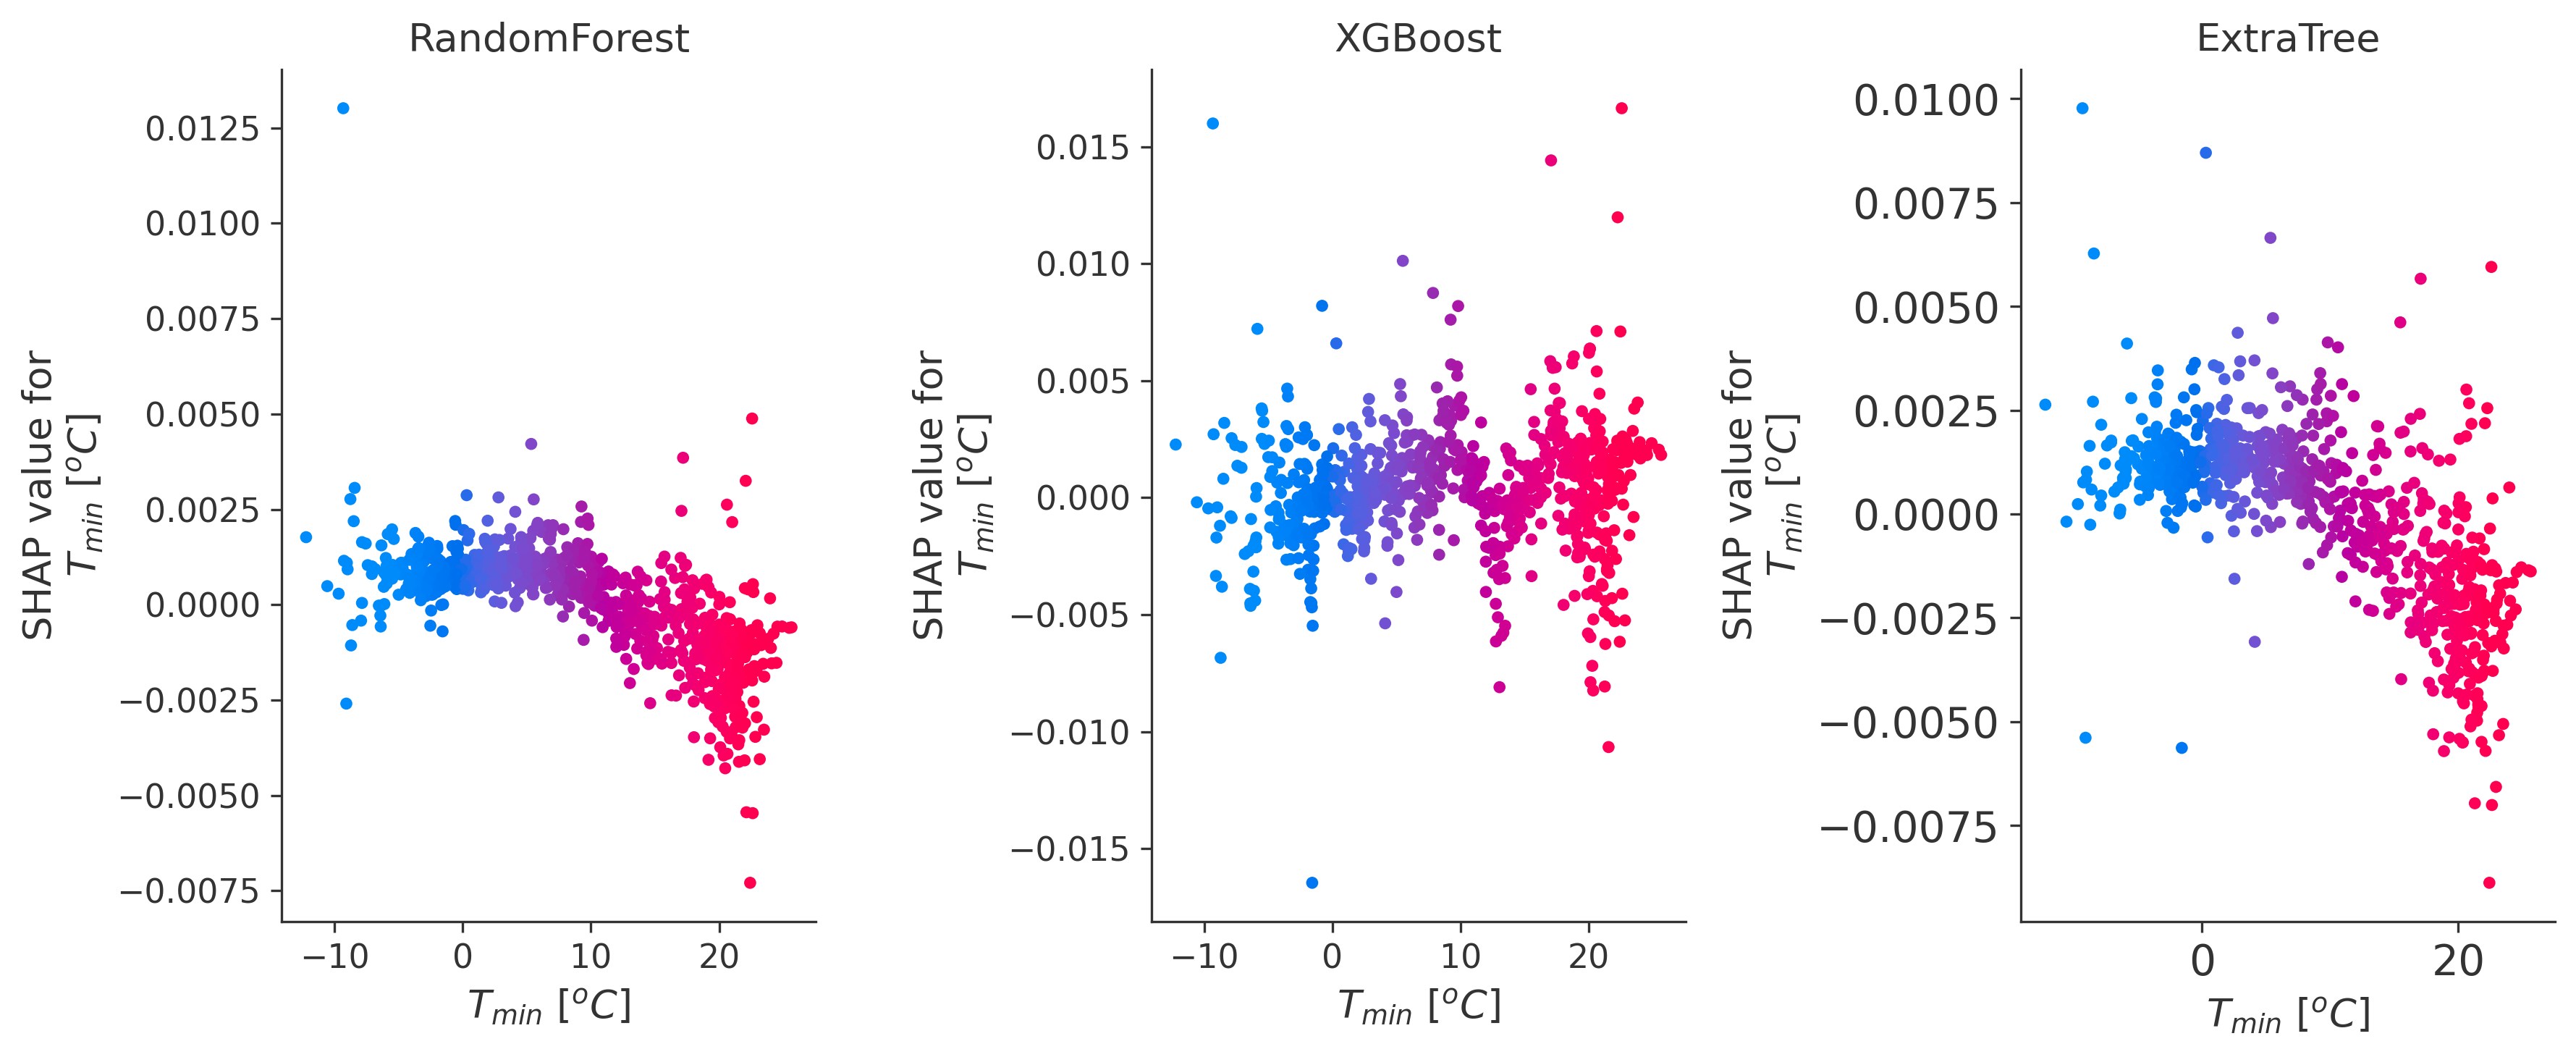

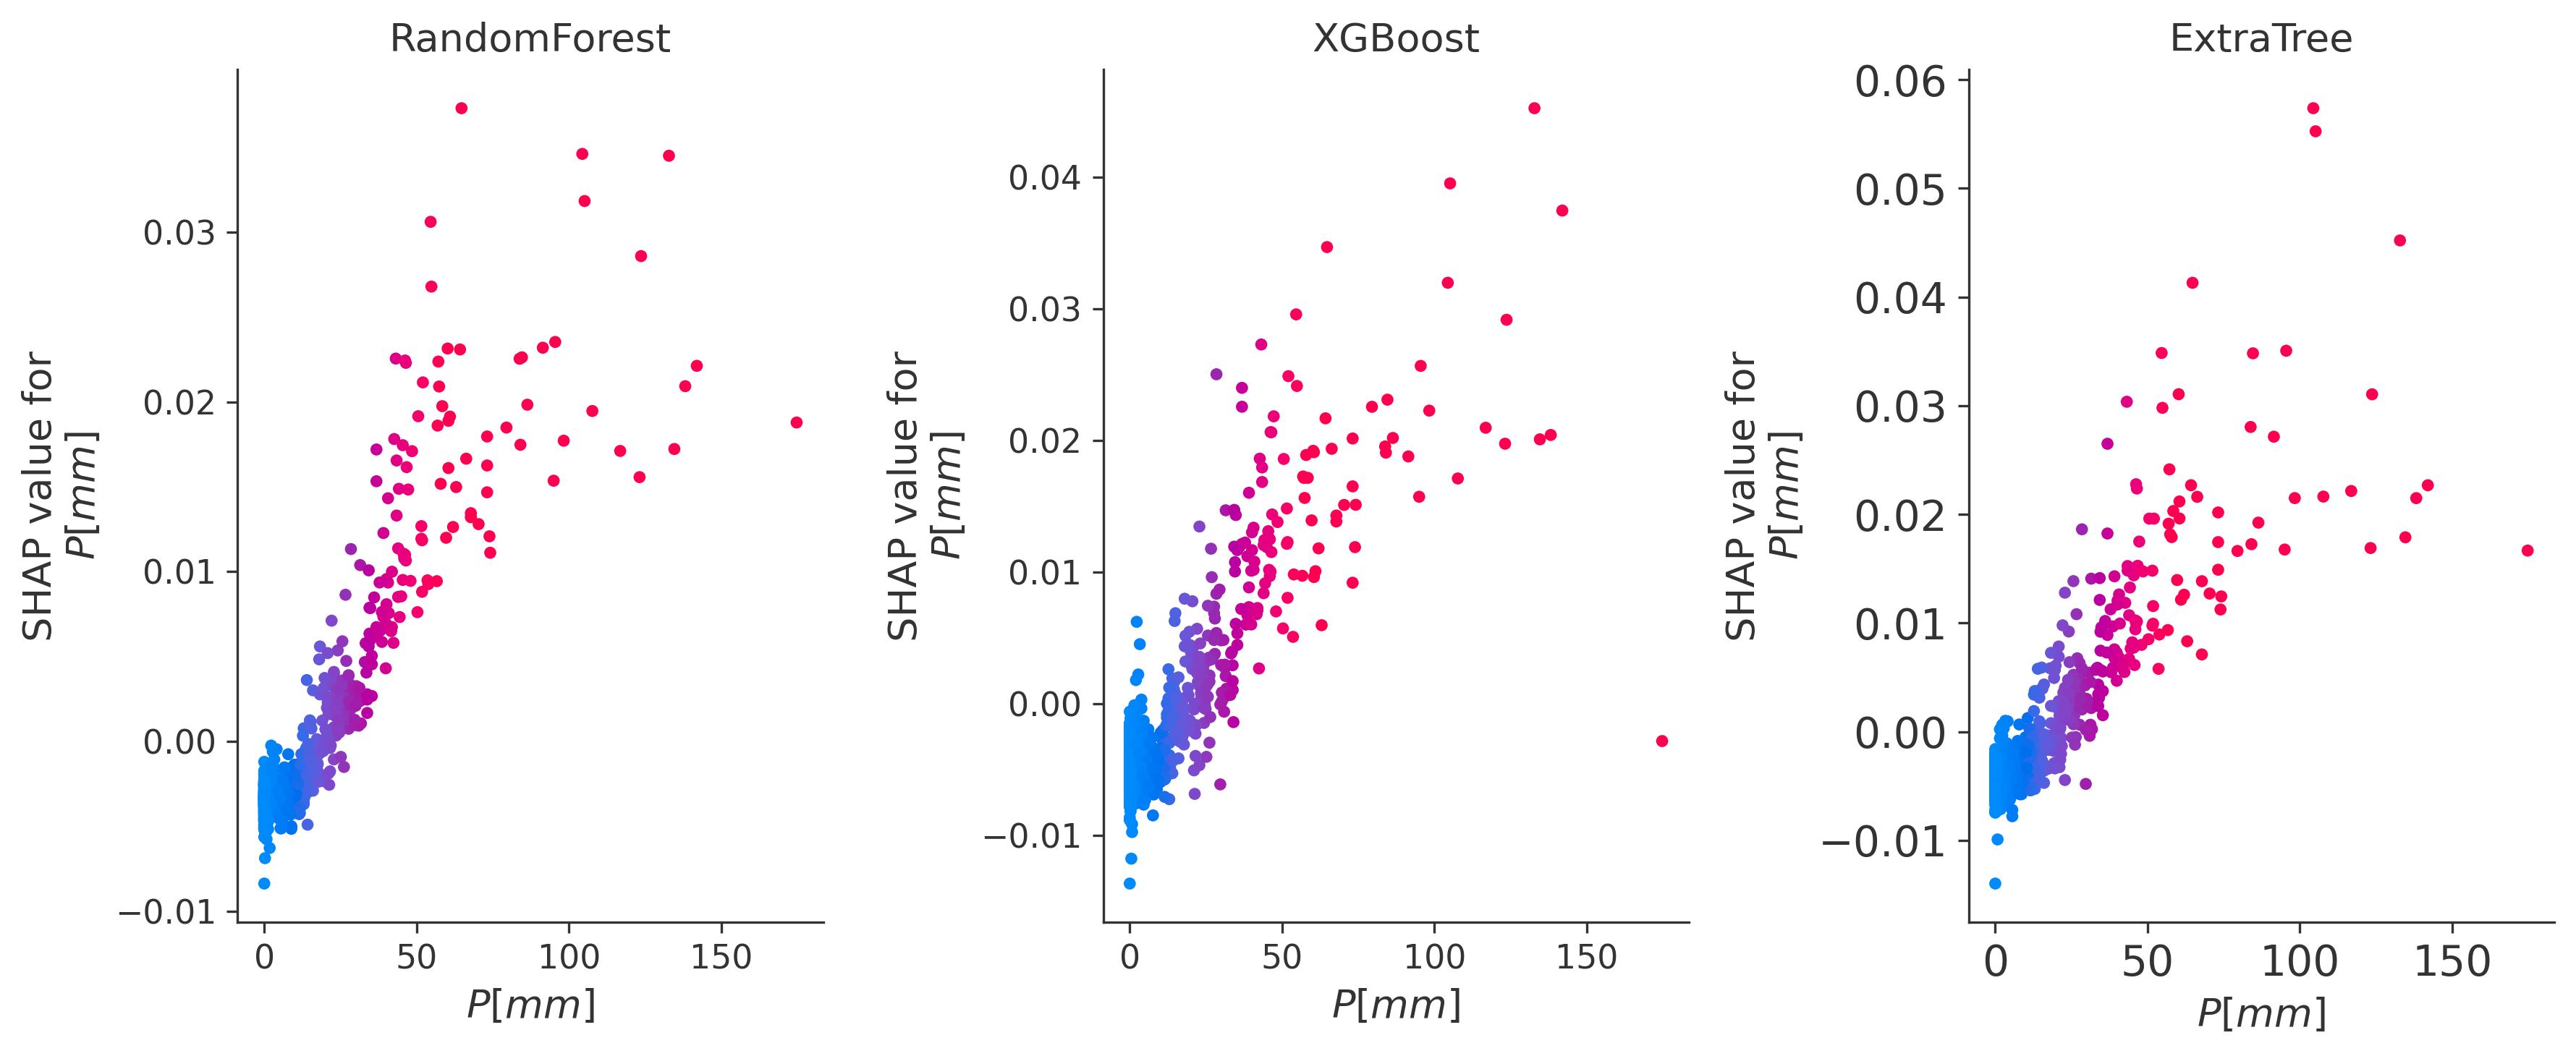

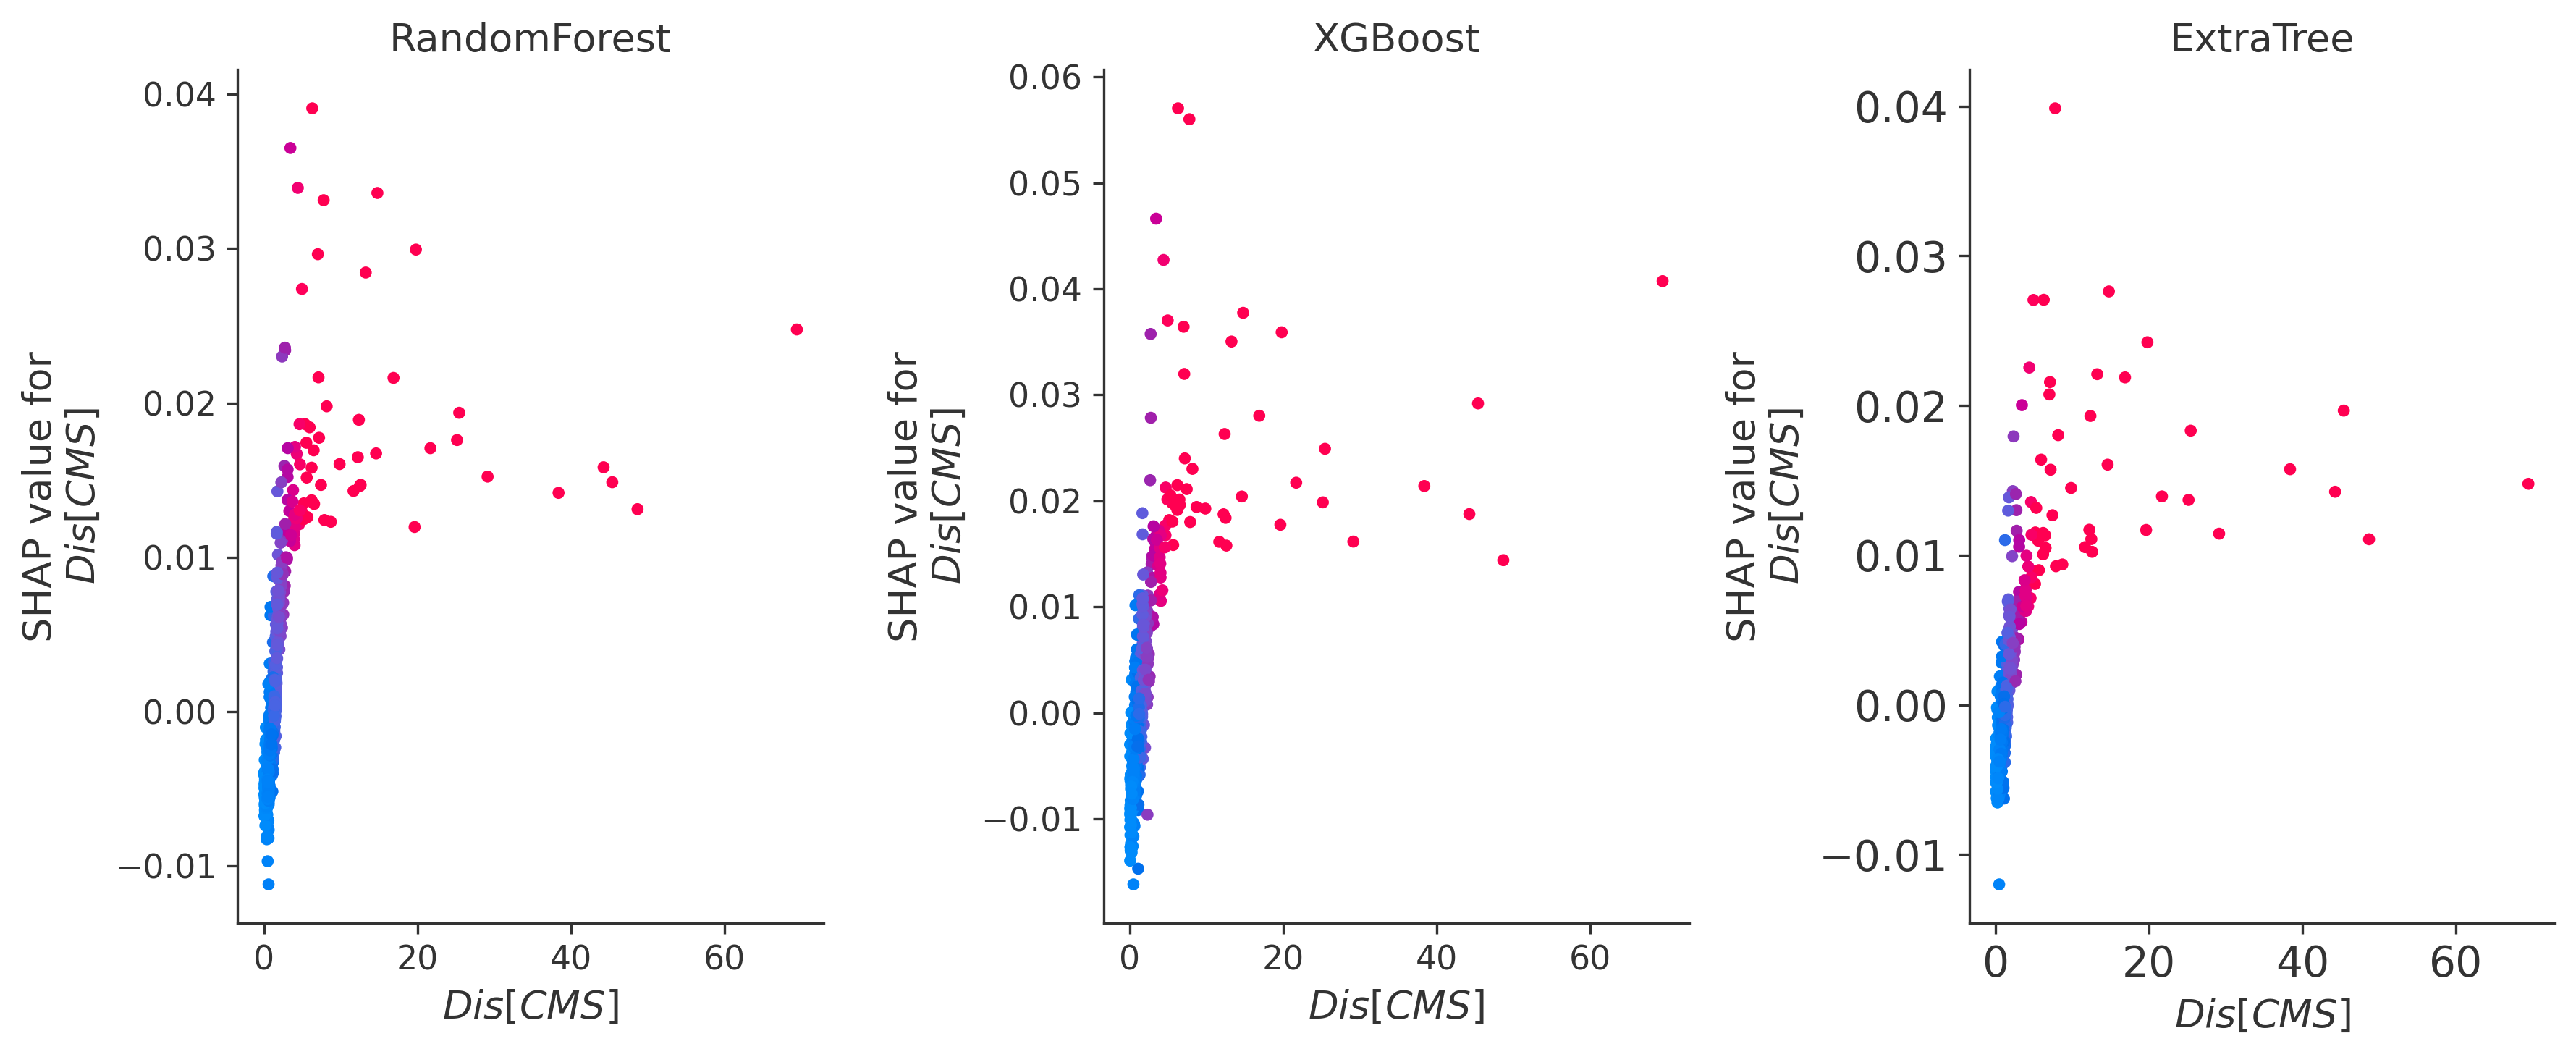

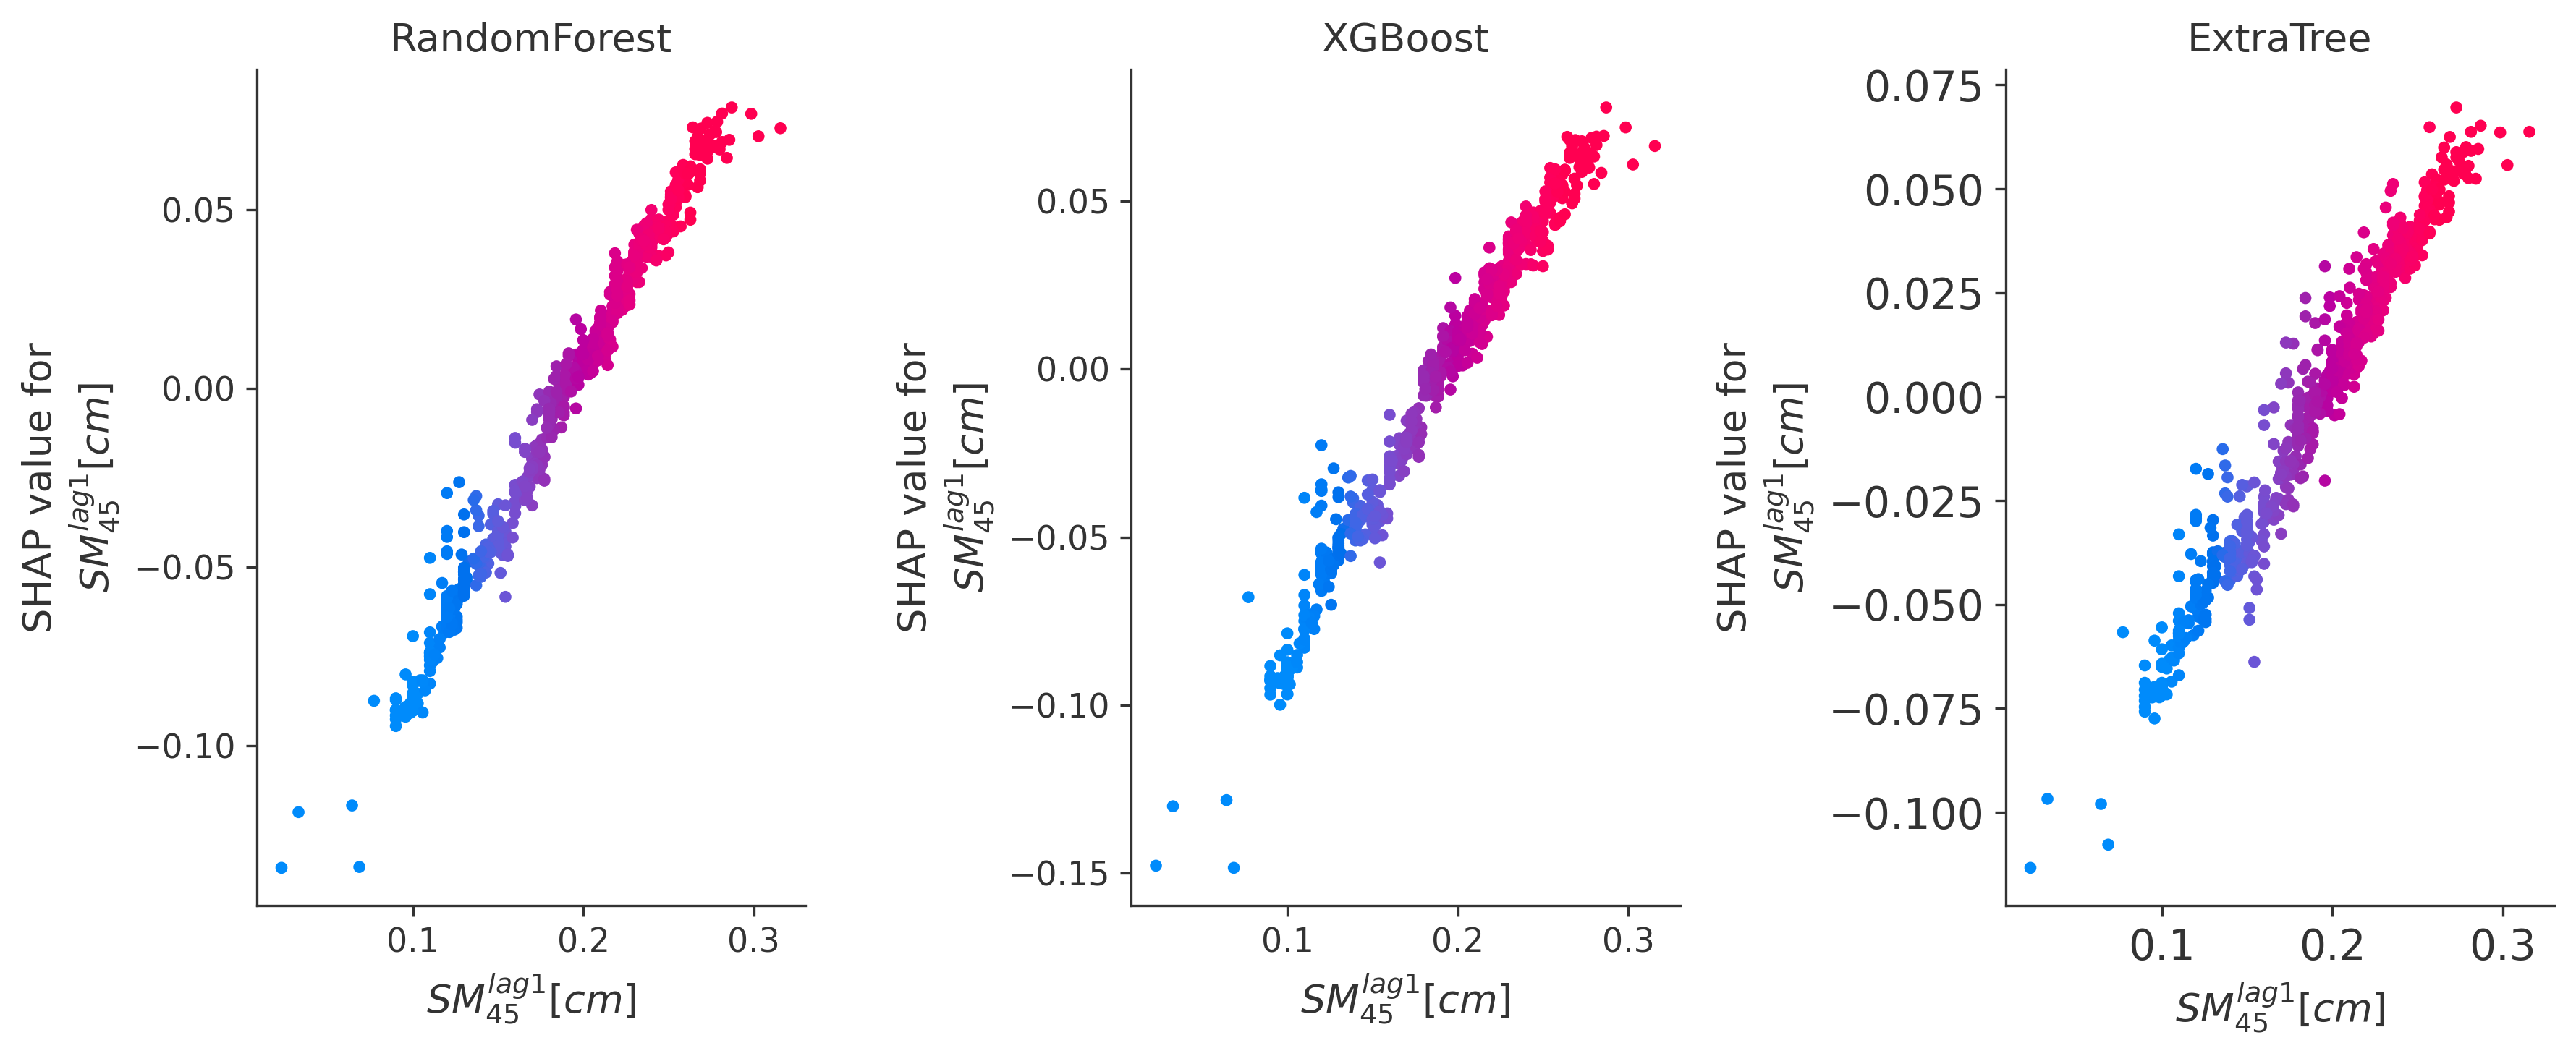

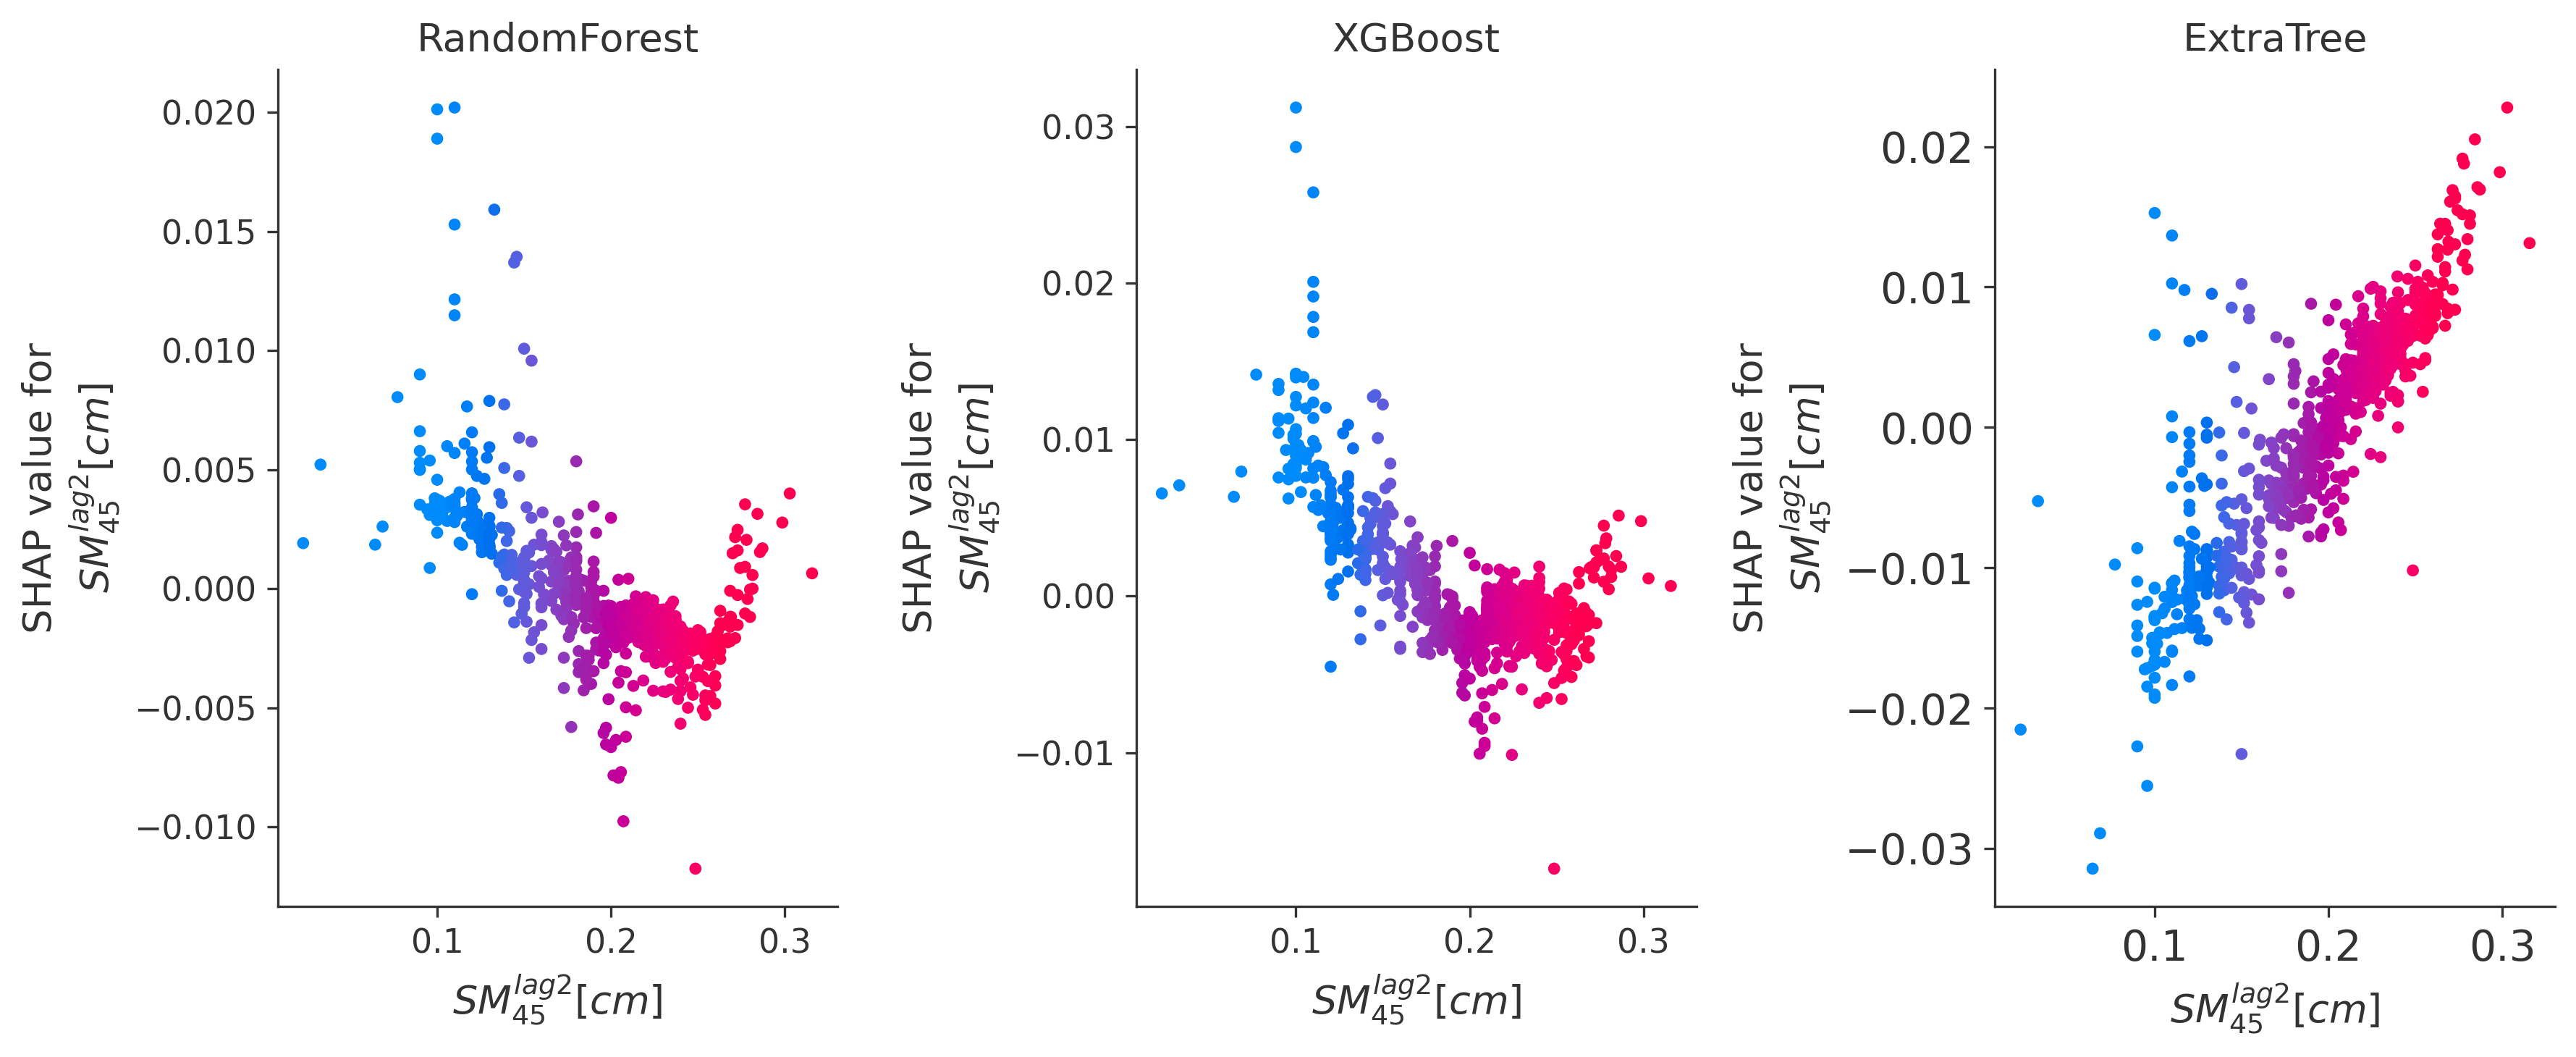

In [254]:
for i in Features:
    fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=300)
    for count, j in enumerate(keep):
        shap.dependence_plot(i, keep[j], X, Features, ax=ax[count], show=False,
                             interaction_index=i, title=j)
        #ax[count].title(j, fontsize=14)
        plt.tick_params(labelsize=14)
        # plt.ylabel(labelsize=16)
        plt.tight_layout(pad=1.2)
        plt.savefig(path_to_save+r'/Feature Interaction_' + str(i)+'.jpg',
                    format='jpeg', dpi=300, bbox_inches='tight')


The above feature dependency plot is to be improved as we get more data. 

# Load the yearly crop yield and SPEI data

In [243]:
current_directory = os.getcwd()
file_location = r'/Inputs/Lake Creek Crop Yield Data.xlsx'

crop_yield = pd.read_excel(
    current_directory+file_location, engine="openpyxl", sheet_name=None)
crop_yield.keys()


dict_keys(['Lake Wheat Acres Planted', 'Caddo County Wheat Yield'])

In [244]:
crop_yield = crop_yield['Caddo County Wheat Yield'].set_index("Year").dropna()
crop_yield = crop_yield.iloc[::-1]

In [245]:
current_directory = os.getcwd()
file_location = r'/Inputs/caddo_SPEI.xlsx'

spei = pd.read_excel(
    current_directory+file_location, engine="openpyxl", sheet_name="spei12")

spei_yearly = spei.sort_values(by = 'Years').set_index("Years")
spei_yearly["SPEI_Avg"] = spei_yearly.median(axis=1)

spei_yearly

January  February     March     April       May      June      July  \
Years                                                                         
2005   0.692891  0.658830  0.626736  0.623681  0.386359  0.185556 -0.754535   
2006  -1.189809 -0.743368 -0.715544 -0.898656 -1.287888 -1.635249 -1.519577   
2007  -1.000719 -1.382129 -1.272528 -0.858911 -0.372118 -0.032010  0.077754   
2008   0.319644  0.276725  0.311596  0.260692 -0.099689 -0.784707 -1.026468   
2009  -0.962900 -1.028821 -1.039983 -1.196946 -0.933294 -1.163769 -1.099613   
2010  -0.518602 -0.280066 -0.234259 -0.191034 -0.470581 -0.683458 -0.423537   
2011   0.507130  0.357049  0.320285  0.207243  0.243664 -0.127219 -0.822131   
2012  -0.529808 -0.490832 -0.436625 -0.204984 -0.260985 -0.050872  1.017498   
2013   1.358892  1.357672  1.359228  1.401475  1.443698  1.529206  0.911806   
2014  -0.438112 -0.437463 -0.353085 -0.522718 -0.640600 -0.726405 -0.694243   
2015  -0.346815 -0.392025 -0.400786 -0.237056  0.244486  0.092622 -0.154837   
2016  -0.183112 -0.280313 -0.290039 -0.324410 -0.922419  0.344178  1.134106   
2017   1.855559  1.859770  1.836118  1.837537  1.837246  1.684725  1.455869   
2018   0.364469  0.396648  0.393494  0.366928  0.301151  0.163160  0.665139   
2019   1.450995  1.447438  1.478213  1.516896  1.634343  1.754414  1.838445   
2020   1.564285  1.543043  1.527136  1.519278  1.484406  1.519161  0.898944   

         August  September   October  November  December  SPEI_Avg  
Years                                                               
2005  -0.752786  -0.646098 -0.745894 -1.045667 -0.969127 -0.230271  
2006  -1.558175  -1.486743 -1.408062 -1.386774 -1.335303 -1.361039  
2007   0.183817   0.277200  0.255452  0.279254  0.353062  0.022872  
2008  -1.032757  -0.944029 -0.935555 -0.980360 -1.005906 -0.860131  
2009  -1.171727  -0.981808 -0.776066 -0.769442 -0.644756 -1.005315  
2010   0.534147   0.543563  0.405034  0.480806  0.504638 -0.212647  
2011  -1.120246  -1.170623 -1.086493 -0.679472 -0.544386 -0.335802  
2012   1.122330   1.461492  1.455568  1.333444  1.356779  0.483313  
2013  -0.116280  -1.053393 -1.024995 -0.913452 -0.808401  1.134739  
2014  -0.619805  -0.435504 -0.520823 -0.468925 -0.166474 -0.494874  
2015  -0.274014  -0.164746 -0.063934 -0.028770 -0.226820 -0.195783  
2016   1.600800   1.769062  1.738976  1.810354  1.842676  0.739142  
2017   0.872419   0.622366  0.688829  0.476839  0.536120  1.570297  
2018   1.158093   1.317079  1.360053  1.395971  1.448067  0.530893  
2019   1.772651   1.597674  1.557198  1.576223  1.594557  1.585390  
2020   0.769669   0.305420  0.305170  0.305529  0.402229  1.191675

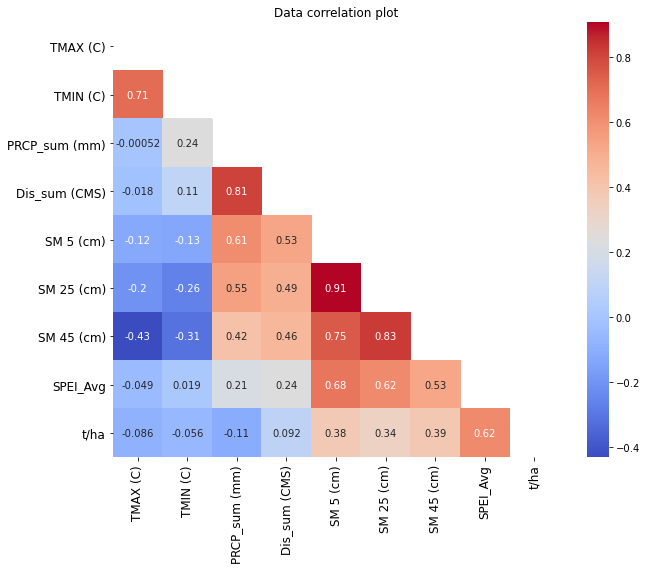

In [246]:
# Resample the temperature
resampled_yearly = df_F108[['TMAX (C)', "TMIN (C)"]].resample('Y').median()
# Resample the Precipitation & Discharge sum
resampled_yearly["PRCP_sum (mm)"] = df_F108["PRCP (mm)"].resample('Y').sum()
resampled_yearly["Dis_sum (CMS)"] = df_F108["CMS"].resample('Y').sum()
# Resample the SM
resampled_SM_yearly = df_F108.iloc[:, 4:].resample('Y').median()
# The transformed precipitation mean and median

df_F108_resampled_yearly = resampled_yearly.merge(resampled_SM_yearly, on='Date', how="inner")

df_F108_resampled_yearly['SPEI_Avg'] = spei_yearly["SPEI_Avg"].values

# df_F108_resampled_yearly['bu/ac *'] = crop_yield['bu/ac *'].values
df_F108_resampled_yearly['t/ha'] = crop_yield['t/ha'].values

corr_plot(df_F108_resampled_yearly, 'Data correlation plot')
